In [47]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
from scipy.optimize import minimize
import matplotlib.ticker as mtick

In [48]:
inicio = dt.date(2013, 1, 2)
final = dt.date(2022, 12, 30)

In [49]:
precos = pd.read_excel('DataIndices.xlsx', index_col='Data')
lista_precos = precos.columns.tolist()
# lista_precos = precos.shape[1]

print(len(lista_precos))

11


In [50]:
retornos = precos.pct_change().apply(lambda x: np.log(1+x)).dropna() # Retorno Logarítmo
media_retornos = retornos.mean()
matriz_cov = retornos.cov()

media_retornos

IMA-B 5+    0.000398
IMA-B       0.000396
IMA-B 5     0.000404
IRF-M 1     0.000338
CDI         0.000326
110% CDI    0.000326
IFMM        0.000385
IBOV        0.000345
SMLL        0.000331
IFIX        0.000276
BDRX        0.001008
dtype: float64

In [51]:
numero_carteiras = 100000
df_retornos_esperados= np.zeros(numero_carteiras)
df_volatilidades_esperadas = np.zeros(numero_carteiras)
df_sharpe = np.zeros(numero_carteiras)
df_pesos = np.zeros((numero_carteiras, len(lista_precos)))

for k in range(numero_carteiras):
    
    pesos = np.random.random(len(lista_precos))
    pesos = pesos / np.sum(pesos)
    df_pesos[k, :] = pesos
    
    df_retornos_esperados[k] = np.sum(media_retornos * pesos * 252)
    df_volatilidades_esperadas[k] = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov * 252, pesos)))
    
    df_sharpe[k] = df_retornos_esperados[k] / df_volatilidades_esperadas[k]

In [52]:
indice_sharpe_maximo = df_sharpe.argmax()
df_pesos[indice_sharpe_maximo]

array([6.38550025e-02, 1.12547223e-02, 1.42049920e-01, 2.10641748e-01,
       2.12048657e-01, 1.84297197e-01, 5.89755275e-02, 2.20348383e-05,
       2.38214239e-02, 1.54702463e-02, 7.75635202e-02])

In [53]:
df_retornos_esperados_arit = np.exp(df_retornos_esperados) - 1
df_retornos_esperados_arit

array([0.12744169, 0.10665628, 0.11593105, ..., 0.12089303, 0.09641947,
       0.11156159])

In [54]:
eixoY_fronteira_eficiente = np.linspace(df_retornos_esperados_arit.min(),
                                        df_retornos_esperados_arit.max(), 50)

def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    retorno = np.sum(media_retornos * peso_teste) * 252
    retorno = np.exp(retorno) - 1
    
    return retorno

def chacando_soma_pesos(peso_teste):
    
    return np.sum(peso_teste) - 1

def pegando_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol = df_volatilidades_esperadas[k] = np.sqrt(np.dot(peso_teste.T, np.dot(matriz_cov*252, peso_teste)))
    
    return vol

peso_inicial = [1/len(lista_precos)] * len(lista_precos)
limites = tuple([0, 1] for ativo in lista_precos)

eixoX_fronteira_eficiente = []

for retorno_possivel in eixoY_fronteira_eficiente:
    # Vamos pegar a melhor volatilidade para cada retorno possível
    
    restricoes = ({'type':'eq', 'fun':chacando_soma_pesos},
                 {'type':'eq', 'fun': lambda w: pegando_retorno(w) - retorno_possivel})
    
    result = minimize(pegando_vol, peso_inicial, method='SLSQP', bounds=limites,
                     constraints=restricoes)
    eixoX_fronteira_eficiente.append(result['fun'])

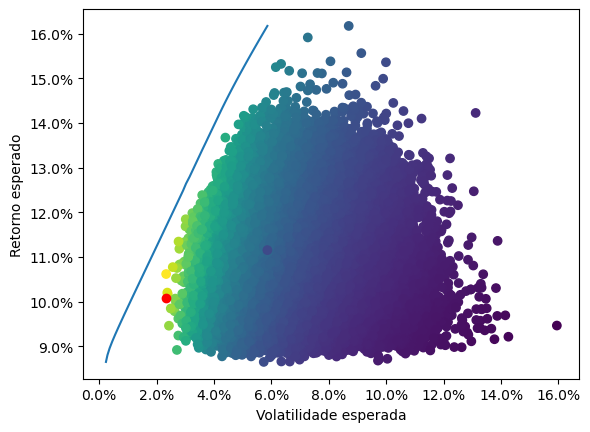

In [55]:
fig, ax = plt.subplots()

ax.scatter(df_volatilidades_esperadas, df_retornos_esperados_arit, c= df_sharpe)
plt.xlabel('Volatilidade esperada')
plt.ylabel('Retorno esperado')
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
ax.scatter(df_volatilidades_esperadas[indice_sharpe_maximo],
          df_retornos_esperados[indice_sharpe_maximo], c = 'red')
ax.plot(eixoX_fronteira_eficiente, eixoY_fronteira_eficiente)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# ax.tick_params(axis='y', colors='white')
# ax.tick_params(axis='x', colors='white')

plt.show()